## Names: Lilach Pardess & Assaf Taubenfeld

In this homework assignment, you are requested to implement a full backprop algorithm using only *numpy*.

- We assume sigmoid activation across all layers.
- We assume a single value in the output layer

The following class represents a simple feed forward network with multiple layers. The network class provides methods for running forward and backward for a single instance, throught the network. You should implement the methods (indicated with TODO), that performs forward and backward for an entire batch. Note, the idea is to use matrix multiplications, and not running standard loops over the instances in the batch.

In [1]:
#Names: Lilach Pardess & Assaf Taubenfeld
import numpy as np
import pandas as pd
np.random.seed(42)

In [2]:
#@title MyNN implementation

class MyNN:
  def __init__(self, learning_rate, layer_sizes):
    '''
    learning_rate - the learning to use in backward
    layer_sizes - a list of numbers, each number repreents the nuber of neurons
                  to have in every layer. Therfore, the length of the list
                  represents the number layers this network has.
    '''
    self.learning_rate = learning_rate
    self.layer_sizes = layer_sizes
    self.model_params = {}
    self.memory = {}
    self.grads = {}

    # Initializing weights: For each wights layer (between 2 layers of neurons)
    # create a metrix ('W_') of shapre (W_input, W_output) and bias vector
    # ('b_') of shape (W_input)
    # W_input = number of nuerons in the next layer
    # W_output = number of nuerons in the current layer.
    for layer_index in range(len(layer_sizes) - 1):
      W_input = layer_sizes[layer_index + 1]
      W_output = layer_sizes[layer_index]
      self.model_params['W_' + str(layer_index + 1)] = np.random.randn(W_input, W_output) * 0.1
      self.model_params['b_' + str(layer_index + 1)] = np.random.randn(W_input) * 0.1

  def forward_single_instance(self, x):
    """
      Calaculate the forward step for one data input

      Args:
          x: The data point to process

      Returns:
          a_i_1: The activation of the last layer
    """
    # self.memory[a_i] represent the activation values of the i'th layer. In the
    # first layer, the values are the input, x.
    a_i_1 = x
    self.memory['a_0'] = x
    # For each layer,
    # 1. Get its Wights and Bias
    # 2. Calaculate z values based on activation from prev layer
    # 3. Use Sigmoid to claculate the current layer activation
    # 4. store in memory and update the activation values for next iteration
    for layer_index in range(len(self.layer_sizes) - 1):
      W_i = self.model_params['W_' + str(layer_index + 1)]
      b_i = self.model_params['b_' + str(layer_index + 1)]
      z_i = np.dot(W_i, a_i_1) + b_i
      a_i = 1/(1+np.exp(-z_i))
      self.memory['a_' + str(layer_index + 1)] = a_i
      a_i_1 = a_i
    return a_i_1

  def log_loss(self, y_hat, y):
    """
      Logistic loss, assuming a single value in y_hat and y.
      Calculates the loss for a singal data point. Use cross entropy formula for
      loss calaculation

      Args:
          y_hat: the model's output for single data point
          y: the actual value.

      Returns:
          cost: the loss for the single data point.
    """
    m = y_hat[0]
    cost = -y[0]*np.log(y_hat[0]) - (1 - y[0])*np.log(1 - y_hat[0])
    return cost

  def backward_single_instance(self, y):
    """
       Calculates the backward step for one data input. This includes calaculte
       the gradients for the different wights and bias and store them in memory

      Args:
          y - the label of the instance which the model processed.

      Returns:
          void (update the memory)
    """

    # Get y_hat which is the activation we calaculated for the last layer and
    # calculate dz for output layer
    a_output = self.memory['a_' + str(len(self.layer_sizes) - 1)]
    dz = a_output - y

    for layer_index in range(len(self.layer_sizes) - 1, 0, -1):
      print(layer_index)
      # Get the activation of the layer
      a_l_1 = self.memory['a_' + str(layer_index - 1)]

      # Calculate dW and store it in memory
      dW = np.dot(dz.reshape(-1, 1), a_l_1.reshape(1, -1))
      self.grads['dW_' + str(layer_index)] = dW

      # Calculate db and store it in memory
      db = dz
      self.grads['db_' + str(layer_index)] = db

      # Calculate and update dz for next layer
      W_l = self.model_params['W_' + str(layer_index)]
      dz = (a_l_1 * (1 - a_l_1)).reshape(-1, 1) * np.dot(W_l.T, dz.reshape(-1, 1))

  def update(self):
    """
      Update weights with grads value calaculate in backward step based on
      Upage rule = W_x = W_x + -learning_rate * dW (and similarity for db)
    """
    for layer_index in range(len(self.layer_sizes) - 1):
      # Update Wights
      W_i = self.model_params['W_' + str(layer_index + 1)]
      W_i = W_i + -self.learning_rate * self.grads['dW_' + str(layer_index + 1)]
      self.model_params['W_' + str(layer_index + 1)] = W_i

      # Update bias
      b_i = self.model_params['b_' + str(layer_index + 1)]
      b_i = b_i + -self.learning_rate * self.grads['db_' + str(layer_index + 1)]
      self.model_params['b_' + str(layer_index + 1)] = b_i


  def forward_batch(self, X):
    """
      Calculates the forward step for batch of data points

      Args:
           X: A metrix where each column represent data instance.
              X.shape = (number_of_features, batch_size)

      Returns:
          y_hat: The activaion metrix of the last layer
    """
    # self.memory[A_i] represent the activation values of the i'th layer. In the
    # first layer, the values are the input, X.
    prev_layer_activations = X
    self.memory['A_0'] = X

    # For each layer,
    # 1. Get its Wights and Bias
    # 2. Calaculate Z values based on activation from prev layer
    # 3. Use Sigmoid to claculate the current layer activation
    # 4. store in memory and update the activation values for next iteration
    for layer_index in range(len(self.layer_sizes) - 1):
      W_i = self.model_params['W_' + str(layer_index + 1)]
      b_i = self.model_params['b_' + str(layer_index + 1)]

      #Multiple W_i with the activations (output) from the prev layer to get Z_i
      Z_i = np.dot(W_i, prev_layer_activations) + b_i.reshape(-1, 1)
      A_i = 1/(1+np.exp(-Z_i))
      self.memory['A_' + str(layer_index + 1)] = A_i
      prev_layer_activations = A_i

    y_hat = self.memory['A_' + str(len(self.layer_sizes) - 1)]
    return y_hat

  def backward_batch(self, Y):
    """
       Calculates the backward step for batch of data points. This includes
       calacultethe gradients for the different wights and bias and store them
       in memory

      Args:
          Y - the labels of the instances which the model processed.
              Y.shape = (1, batch_size)

      Returns:
          void (update the memory)
    """

    # Get Y_hat which is the activation we calaculated for the last layer and
    # calculate dZ for output layer
    A_output = self.memory['A_' + str(len(self.layer_sizes) - 1)]
    dZ = A_output - Y

    for layer_index in range(len(self.layer_sizes) - 1, 0, -1):
      # Get the activations of the layer, batch size
      prev_layer_activations = self.memory['A_' + str(layer_index - 1)]

      # Calculate dW and store it in memory. Make average based on batch size
      batch_size = Y.shape[1]
      dW = (1/batch_size) * np.dot(dZ, prev_layer_activations.T)
      self.grads['dW_' + str(layer_index)] = dW

      # Calculate db and store it in memory
      db = (1/batch_size) * np.sum(dZ, axis=1)
      self.grads['db_' + str(layer_index)] = db

      # Calculate and update dz for next layer
      W_l = self.model_params['W_' + str(layer_index)]
      dZ = (W_l.T @ dZ) * (prev_layer_activations * (1- prev_layer_activations))


  def log_loss_batch(self, Y_hat, Y):
    """
      Logistic loss, assuming Y_hat and Y represent a size of a batch.
      Calculates the loss for a batch of data points.

      Args:
          Y_hat: the model's output for a batch of data points
          Y: the actual values.

      Returns:
          cost: The average loss of the run
    """
    m = Y.shape[1]
    cost = (1 /m) * np.sum(-Y*np.log(Y_hat) - (1 - Y)*np.log(1 - Y_hat))
    return cost

In [3]:
#@title Train method

import numpy as np
def train(X, y, epochs, batch_size):
  """
    Train procedure for the neural network.

    Args:
      X: input data, shape (num_features, num_examples)
      y: true labels, shape (output_size, num_examples)
      epochs: number of passes over the entire dataset
      batch_size: number of examples in each batch

  """

  num_examples = X.shape[1]
  for e in range(1, epochs + 1):
    epoch_loss = 0
    # Step 1: shuffle the data
    # Create a random permutation of indices
    permutation = np.random.permutation(num_examples)
    # Apply this permutation to both X and y along the examples axis (axis 1)
    X_shuffled = X[:, permutation]
    y_shuffled = y[:, permutation]

    # Step 2. Divide the shuffled data into batches
    batches = []
    for i in range(0, num_examples, batch_size):
      # Slice the shuffled data to create the a batch.
      X_b = X_shuffled[:, i:i + batch_size]
      y_b = y_shuffled[:, i:i + batch_size]
      batches.append((X_b, y_b))

    # Step 3. Run the network on the batches.
    for X_b, y_b in batches:
      y_hat = nn.forward_batch(X_b)
      epoch_loss += nn.log_loss_batch(y_hat, y_b)
      nn.backward_batch(y_b)
      nn.update()
    print(f'Epoch {e}, loss={epoch_loss/len(batches)}')

In [4]:
#@title Test single_instance processing
nn = MyNN(0.01, [3, 2, 1])
nn.model_params
x = np.random.randn(3)
y = np.random.randn(1)

y_hat = nn.forward_single_instance(x)
nn.backward_single_instance(y)

2
1


In [ ]:
#@title Test batch processing
nn = MyNN(0.001, [2, 4, 3, 1])

X = np.random.randn(2, 100)
y = np.random.randn(1, 100)
batch_size = 8
epochs = 10

train(X, y, epochs, batch_size)

#TODO: train on an external dataset

Train on the *hour.csv* file with a split of 75% training 10% validation and 15% for test.
Use the following features from the data:

* temp
* atemp
* hum
* windspeed
* weekday

The response variable is, *success*

The architecture of the network should be: [5, 40, 30, 10, 7, 5, 3, 1].

Use batch_size=8, and train it for 100 epochs on the train set (based on the split as requested above).

Then, plot train and validation loss per epoch.

In [8]:
#@title  Helper Functions

def load_data(file_path):
    """
      Load the data from the CSV file to numpy array

      Args:
          file_path (str): The path to the CSV file.

      Returns:
          numpy array: The loaded data from the file in the csv file
    """
    data = np.genfromtxt(
        file_path,
        delimiter=",",
        skip_header=0,
        dtype=None,
        encoding='utf-8-sig'
    )
    return data

def calculate_means_stds_for_z_score_normalization(X_train):
    """
    Calaculate the means and stds of the features in the training set.

    Args:
        X_train: NumPy ndarray, The training set to process.

    Returns:
        Two dictionaries: (means, stds)
          - means: {feature_name: mean_value}
          - stds: {feature_name: std_dev_value}
    """
    means = np.mean(X_train, axis=0)
    stds = np.std(X_train, axis=0)
    return means, stds


def apply_z_score_normalization(X, means, stds):
    """
    Applies Z-score normalization to a given data frame using means and stds

    Args:
        X: NumPy ndarray, The data to normalize.
        means (dict): Dictionary of feature means from the training set.
        stds (dict): Dictionary of feature standard deviations from the training set.

    Returns:
        NumPy ndarray: new data frame with normalized values.
    """
    # Avoid division by zero if a feature had zero standard deviation in the training set.
    # If std was 0, the normalized value will be 0 (as X - mean would also be 0 for those constant features).
    stds_safe = np.where(stds == 0, 1, stds)

    X_normalized = (X - means) / stds_safe
    return X_normalized


def split_data(X, y, train_ratio, val_ratio, test_ratio, random_state=42):
  """
    Shuffle the data and split it into train, validation and test sets

    Args:
        X (ndarray): The features.
        y (ndarray): The labels.
        train_ratio (float): The ratio of the train set.
        val_ratio (float): The ratio of the validation set.
        test_ratio (float): The ratio of the test set.

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test: splited data into train,
        validation and test sets
  """

  np.random.seed(random_state)
  num_samples = X.shape[0]

  # Shuffle indices
  indices = np.random.permutation(num_samples)

  # Compute split sizes
  test_count = int(num_samples * test_ratio)
  val_count = int(num_samples * val_ratio)
  train_count = int(num_samples * train_ratio)

  # Slice the indices
  test_idx = indices[:test_count]
  val_idx = indices[test_count:test_count + val_count]
  train_idx = indices[test_count + val_count:]

  # Index into data
  X_train, y_train = X[train_idx], y[train_idx]
  X_val, y_val     = X[val_idx], y[val_idx]
  X_test, y_test   = X[test_idx], y[test_idx]

  return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
#@title DataLoader

class DataLoader:
    def __init__(self, X, y, batch_size=8, shuffle=True):
        """
        Initialize a simple NumPy-based data loader.

        Parameters:
            X (ndarray): Input data, shape (N, ...)
            y (ndarray): Labels, shape (N,)
            batch_size (int): Number of samples per batch
            shuffle (bool): Whether to shuffle data each epoch
        """
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.current = 0
        self.num_samples = X.shape[0]
        self.indices = np.arange(self.num_samples)

    def __iter__(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.current = 0
        return self

    def __next__(self):
        if self.current >= self.num_samples:
            raise StopIteration
        start = self.current
        end = min(start + self.batch_size, self.num_samples)
        batch_idx = self.indices[start:end]
        self.current = end
        return self.X[batch_idx], self.y[batch_idx]

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

In [11]:
#@title Preprocessing

# load the hour.csv file
all_data = load_data("hour.csv")

# extract the relevant features and labels
header = all_data[0]
feature_names = ["temp", "atemp", "hum", "windspeed", "weekday"]
features_headers = [np.where(header == name)[0][0] for name in feature_names]
features = all_data[1:, features_headers].astype(float)

label = ["success"]
labels_headers = [np.where(header == name)[0][0] for name in label]
labels = all_data[1:, labels_headers]
labels_numeric = (labels == "TRUE").astype(float)

X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    features,
    labels_numeric,
    0.75,
    0.10,
    0.15
)

# Normalize all the features, using z-score normalization.
# First, calaculate the means and stds (only on training data)
# Than use it to normalize all the data.
means, stds = calculate_means_stds_for_z_score_normalization(X_train)
X_train_normalized = apply_z_score_normalization(X_train, means, stds)
X_val_normalized = apply_z_score_normalization(X_val, means, stds)
X_test_normalized = apply_z_score_normalization(X_test, means, stds)


In [16]:
#@title Model Training

# Hyperparameters
network_architecture = [5, 40, 30, 10, 7, 5, 3, 1]
learning_rate = 0.001
epochs = 100
batch_size = 8

network = MyNN(learning_rate, network_architecture)

train_data_loader = DataLoader(
    X_train_normalized, y_train, batch_size=batch_size, shuffle=True
)

val_data_loader = DataLoader(
    X_val_normalized, y_val, batch_size=batch_size, shuffle=False
)

train_losses = []
val_losses = []

for epoch in range(epochs):

  # Calculate the loss for training, and update wights
  training_epoch_loss = 0
  for X_b, y_b in train_data_loader:

    # Take the transpose if X_b to have the shape (#features, #instances)
    y_hat = network.forward_batch(X_b.T)
    training_epoch_loss += network.log_loss_batch(y_hat, y_b.T)
    network.backward_batch(y_b.T)
    network.update()

  # Store training loss
  train_losses.append(training_epoch_loss/len(train_data_loader))

  # Calaculte the loss for validation, only forward pass.
  epoch_val_loss = 0
  for X_b, y_b in val_data_loader:
    y_hat = network.forward_batch(X_b.T)
    batch_loss = network.log_loss_batch(y_hat, y_b.T)
    epoch_val_loss += batch_loss

  val_losses.append(epoch_val_loss / len(val_data_loader))

  #Track progress
  #print(f'Epoch {epoch}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

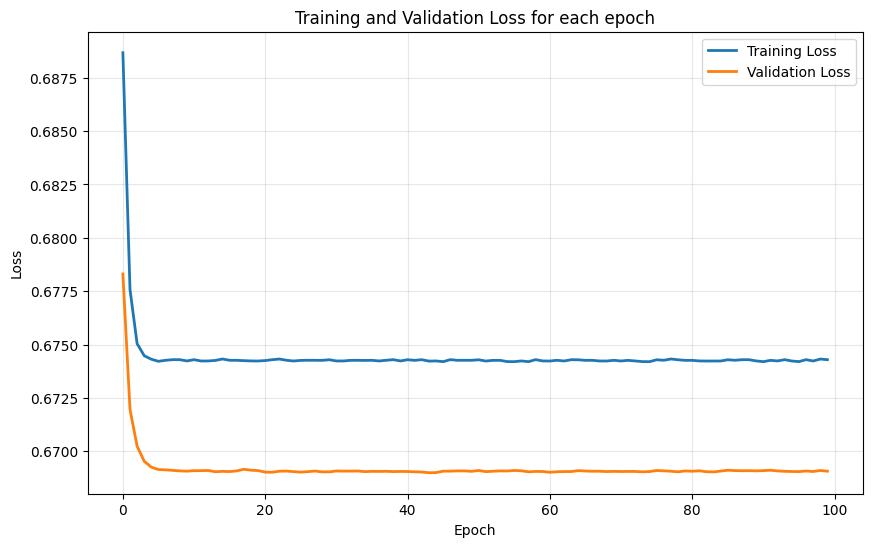


Model Performance Analysis:

Initial Training Loss: 0.6887
Final Training Loss: 0.6743
Final Validation Loss: 0.6691


In [17]:
#@title Visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', linewidth=2)
plt.plot(range(epochs), val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for each epoch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# brif analysis:
print("")
print("Model Performance Analysis:")
print("")
print(f"Initial Training Loss: {train_losses[0]:.4f}")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

In [18]:
#@title Model Evaluation

# TODO: Evaluate model performance on the test set
# - Calculate and report the loss on the test set
# - Calculate and report the accuracy on the test set
# - Compare test performance with training/validation performance
# - Analyze model strengths and weaknesses
# - Discuss any overfitting/underfitting issues observed

'''
First, calaculate the test data while keep track of predictions
for accuracy analysis

For accuracy analysis, I assume:
if y_hat > 0.5 and y = 1 --> correct
if y_hat > 0.5 and y = 0 --> false

if y_hat < 0.5 and y == 0 --> correct
if y_hat < 0.5 and y = 1 --> false
'''

test_data_loader = DataLoader(
    X_test_normalized, y_test, batch_size=batch_size, shuffle=False
)

# Calculate test loss
test_loss = 0
all_predictions = []
all_labels = []

for X_b, y_b in test_data_loader:
    y_hat = network.forward_batch(X_b.T)
    test_loss += network.log_loss_batch(y_hat, y_b.T)

    predictions = (y_hat > 0.5).astype(float)  # Convert probabilities to 0/1
    all_predictions.extend(predictions.flatten())
    all_labels.extend(y_b.flatten())

# Calculate average test loss
avg_test_loss = test_loss / len(test_data_loader)

# Calculate accuracy
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
test_accuracy = np.mean(all_predictions == all_labels)

# Test loss and test accuracy
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print()

# Compate to training and validation losses
print(f"Training Loss: {train_losses[-1]:.4f}")
print(f"Validation Loss: {val_losses[-1]:.4f}")
print(f"Test Loss: {avg_test_loss:.4f}")
print()



'''

Model strength and weeknesses, overfitting and underfitting:

Overall, the model seems to perform not-so-good, with Accuracy of 61.59%.
In the visualization graph we can see that there is an improvment in the first 5
epochs, and than the model platue with a high loss.

We see similar pattarn in training in validation, which means that even though
the model did not learn alot, it learn something and generalize.

Looking at W_ and b_ in the first iterations, I saw that the model seems to have
a vanashing gradients problem, which happens as we are using sigmod function
aover relatily deep network for 5 features (7 layers).

We see that the model in underfitting, with losses very similar in Training,
Validation and Test.

'''

Test Loss: 0.6668
Test Accuracy: 0.6159 (61.59%)

Training Loss: 0.6743
Validation Loss: 0.6691
Test Loss: 0.6668



'\n\nModel strength and weeknesses, overfitting and underfitting:\n\nOverall, the model seems to perform not-so-good, with Accuracy of 61.59%.\nIn the visualization graph we can see that there is an improvment in the first 5\nepochs, and than the model platue with a high loss.\n\nWe see similar pattarn in training in validation, which means that even though \nthe model did not learn alot, it learn something and generalize.\n\nLooking at W_ and b_ in the first iterations, I saw that the model seems to have \na vanashing gradients problem, which happens as we are using sigmod function \naover relatily deep network for 5 features (7 layers). \n\nWe see that the model in underfitting, with losses very similar in Training,\nValidation and Test. \n\n'